### 1. 각 코스별 제출 학생의 숫자와 제출 숙제의 개수

In [1]:
import sqlite3
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd

In [2]:
conn = pymysql.connect(host = 'codeborn-bi-db.cvv1o1yrngie.ap-northeast-2.rds.amazonaws.com',
                        port = 3306,
                        user = 'pikachu',
                        password = 'ufeqqE5W2ILb',
                        db = 'codeborn')
cur = conn.cursor()

In [3]:
# df_assignments, df_student_course_id, df_submissions에 저장
# 각각 assignment_id = 1제외, student_id = 11 제외
df_assignments = pd.read_sql_query(
    "select assignment_id, course_id, problem_id, assignment_title, started_date, ended_date from assignments where assignment_id <> 1;",
    conn)
df_student_course_relation = pd.read_sql_query(
    "select * from student_course_relation where student_id <>11;", conn)
df_submissions = pd.read_sql_query("select submission_id, assignment_id, student_id, submit_date, total_score from submissions where assignment_id <> 1 and student_id <> 11", conn)

df_submissions.head()

,submission_id,assignment_id,student_id,submit_date,total_score
0,2,2,1,2020-07-14 15:00:00,20.0
1,17,2,22,2021-09-18 16:56:20,50.0
2,18,2,22,2021-09-18 16:57:14,50.0
3,23,2,13,2021-09-18 17:24:14,0.0
4,24,2,13,2021-09-18 17:26:30,0.0


In [4]:
# 조교 제외
students_in_course = df_student_course_relation[(df_student_course_relation['teaching_assistant'] == 0)]

# 조교와 테스트 과제를 제외한 테이블끼리 조인
# 수업을 수강하는 학생들이 풀어야하는 과제
asnmt = pd.merge(students_in_course, df_assignments, on="course_id")
asnmt = asnmt[["course_id", "student_id", "assignment_id", "started_date", "ended_date"]]
asnmt.shape

(2049, 5)

In [5]:
sub_asnmt = pd.merge(df_submissions, asnmt, on=['assignment_id', 'student_id'])
# 제시간에 숙제를 제출한 학생들
in_time = sub_asnmt[(sub_asnmt["submit_date"] > sub_asnmt["started_date"]) 
                    & (sub_asnmt["submit_date"] < sub_asnmt["ended_date"])]
in_time = in_time[['course_id', 'assignment_id', 'student_id', 'submission_id']]
in_time.head()

,course_id,assignment_id,student_id,submission_id
30,DSAA-2021,2,13,153
31,DSAA-2021,2,13,240
33,DSAA-2021,2,29,75
34,DSAA-2021,2,29,76
35,DSAA-2021,2,29,77


In [6]:
cnt_student_and_submissions_groupby_course_id = \
in_time.groupby(["course_id"])[["student_id", "submission_id"]].agg(
    {"student_id": lambda x: len(x.unique()),
    "submission_id": "count"}
)

In [7]:
cnt_student_and_submissions_groupby_course_id.head()

,student_id,submission_id
course_id,,
DSAA-2021,38,2386
DSAA-2022,31,1527
PY-2022S,94,10041


In [8]:
list(in_time.groupby(["course_id"])[["student_id", "submission_id"]])[0][1]

,course_id,assignment_id,student_id,submission_id
30,DSAA-2021,2,13,153
31,DSAA-2021,2,13,240
33,DSAA-2021,2,29,75
34,DSAA-2021,2,29,76
35,DSAA-2021,2,29,77
...,...,...,...,...
2635,DSAA-2021,18,20,2924
2636,DSAA-2021,18,20,2925
2637,DSAA-2021,18,26,2920
2638,DSAA-2021,18,26,2921


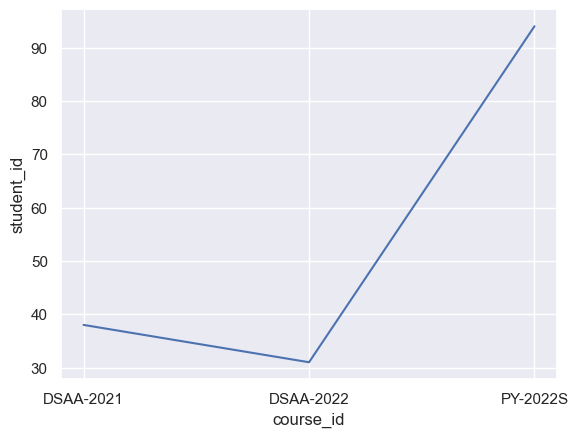

In [9]:
sns.lineplot(x='course_id', 
             y = 'student_id', 
             data=cnt_student_and_submissions_groupby_course_id);

## Answer_1

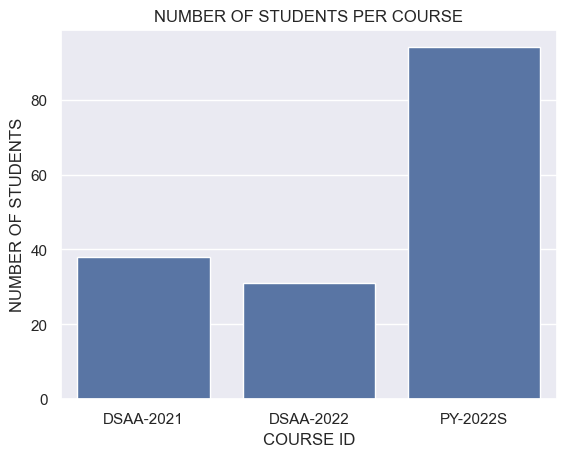

In [10]:
ax = sns.barplot(y="student_id", x=cnt_student_and_submissions_groupby_course_id.index, 
            data=cnt_student_and_submissions_groupby_course_id, color="b")

ax.set(xlabel="COURSE ID", ylabel="NUMBER OF STUDENTS", title="NUMBER OF STUDENTS PER COURSE")
for patches in ax.patches:
    patches.get_height()

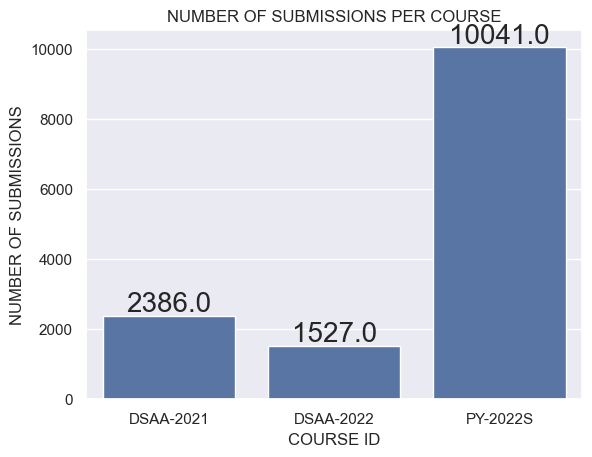

In [11]:
ax = sns.barplot(y="submission_id", x=cnt_student_and_submissions_groupby_course_id.index, 
            data=cnt_student_and_submissions_groupby_course_id, color="b")

ax.set(xlabel="COURSE ID", ylabel="NUMBER OF SUBMISSIONS", title="NUMBER OF SUBMISSIONS PER COURSE")

for bar in ax.patches:
    ax.annotate(round(bar.get_height(), ndigits=2),
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha="center", va="center",
                 xytext=(0, 8),
                 textcoords="offset points",
                 size=20)
plt.show()

### 2번 - 각 코스별, 숙제별로 숙제를 가장 빨리 제출한 학생의 아이디와 제출한 시간을 출력하시오

In [12]:
in_time = sub_asnmt[(sub_asnmt["submit_date"] > sub_asnmt["started_date"]) 
                    & (sub_asnmt["submit_date"] < sub_asnmt["ended_date"])]

in_time = in_time[['course_id', 'assignment_id', 'student_id', 'submit_date', 'started_date']]
in_time.head()

,course_id,assignment_id,student_id,submit_date,started_date
30,DSAA-2021,2,13,2021-09-20 18:30:21,2021-09-19
31,DSAA-2021,2,13,2021-09-23 10:58:08,2021-09-19
33,DSAA-2021,2,29,2021-09-20 01:00:57,2021-09-19
34,DSAA-2021,2,29,2021-09-20 01:01:37,2021-09-19
35,DSAA-2021,2,29,2021-09-20 01:03:21,2021-09-19


In [13]:
submit_date = in_time["submit_date"]
started_date = in_time["started_date"]
in_time["taken_time"] = (submit_date - started_date).dt.total_seconds
in_time

,course_id,assignment_id,student_id,submit_date,started_date,taken_time
30,DSAA-2021,2,13,2021-09-20 18:30:21,2021-09-19,<bound method PandasDelegate._add_delegate_acc...
31,DSAA-2021,2,13,2021-09-23 10:58:08,2021-09-19,<bound method PandasDelegate._add_delegate_acc...
33,DSAA-2021,2,29,2021-09-20 01:00:57,2021-09-19,<bound method PandasDelegate._add_delegate_acc...
34,DSAA-2021,2,29,2021-09-20 01:01:37,2021-09-19,<bound method PandasDelegate._add_delegate_acc...
35,DSAA-2021,2,29,2021-09-20 01:03:21,2021-09-19,<bound method PandasDelegate._add_delegate_acc...
...,...,...,...,...,...,...
20009,DSAA-2022,41,181,2022-12-10 22:21:15,2022-12-06,<bound method PandasDelegate._add_delegate_acc...
20010,DSAA-2022,41,182,2022-12-10 22:49:26,2022-12-06,<bound method PandasDelegate._add_delegate_acc...
20011,DSAA-2022,41,212,2022-12-10 23:39:13,2022-12-06,<bound method PandasDelegate._add_delegate_acc...
20012,DSAA-2022,41,212,2022-12-10 23:42:26,2022-12-06,<bound method PandasDelegate._add_delegate_acc...


In [14]:
in_time['taken_time'] = (in_time['submit_date'] - in_time['started_date']).dt.total_seconds()
in_time

,course_id,assignment_id,student_id,submit_date,started_date,taken_time
30,DSAA-2021,2,13,2021-09-20 18:30:21,2021-09-19,153021.0
31,DSAA-2021,2,13,2021-09-23 10:58:08,2021-09-19,385088.0
33,DSAA-2021,2,29,2021-09-20 01:00:57,2021-09-19,90057.0
34,DSAA-2021,2,29,2021-09-20 01:01:37,2021-09-19,90097.0
35,DSAA-2021,2,29,2021-09-20 01:03:21,2021-09-19,90201.0
...,...,...,...,...,...,...
20009,DSAA-2022,41,181,2022-12-10 22:21:15,2022-12-06,426075.0
20010,DSAA-2022,41,182,2022-12-10 22:49:26,2022-12-06,427766.0
20011,DSAA-2022,41,212,2022-12-10 23:39:13,2022-12-06,430753.0
20012,DSAA-2022,41,212,2022-12-10 23:42:26,2022-12-06,430946.0


In [15]:
first_submit_student = in_time.groupby(["assignment_id"]).first()
first_submit_student.head()

,course_id,student_id,submit_date,started_date,taken_time
assignment_id,,,,,
2,DSAA-2021,13,2021-09-20 18:30:21,2021-09-19,153021.0
3,DSAA-2021,15,2021-09-18 14:30:01,2021-09-01,1521001.0
6,DSAA-2021,28,2021-09-23 10:35:09,2021-09-23,38109.0
8,DSAA-2021,12,2021-09-23 16:06:08,2021-09-23,57968.0
10,DSAA-2021,24,2021-09-26 21:35:40,2021-09-01,2237740.0


## Answer2

- 각 과제별 소요시간

In [16]:
# pip install mpld3

In [17]:
import mpld3

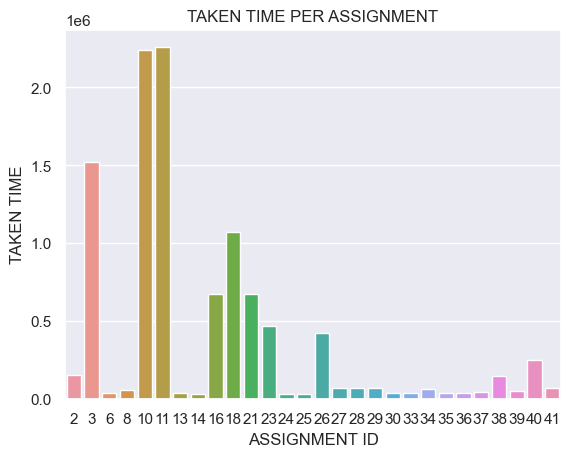

In [18]:
ax = sns.barplot(data=first_submit_student, x=first_submit_student.index, y='taken_time')

ax.set(xlabel="ASSIGNMENT ID", ylabel="TAKEN TIME", title="TAKEN TIME PER ASSIGNMENT")
plt.show()

### 3번 - 각 코스별, 숙제별로 학생들이 숙제를 제출한 횟수를 출력하시오

In [19]:
sub_asnmt = pd.merge(df_submissions, asnmt, on=['assignment_id', 'student_id'])
sub_asnmt.head()

,submission_id,assignment_id,student_id,submit_date,total_score,course_id,started_date,ended_date
0,17,2,22,2021-09-18 16:56:20,50.0,DSAA-2021,2021-09-19,2021-09-25
1,18,2,22,2021-09-18 16:57:14,50.0,DSAA-2021,2021-09-19,2021-09-25
2,39,2,22,2021-09-18 20:56:48,50.0,DSAA-2021,2021-09-19,2021-09-25
3,56,2,22,2021-09-18 23:08:05,75.0,DSAA-2021,2021-09-19,2021-09-25
4,57,2,22,2021-09-18 23:08:55,NaN,DSAA-2021,2021-09-19,2021-09-25


In [20]:
# 제시간에 숙제를 제출한 학생들
in_time = sub_asnmt[(sub_asnmt["submit_date"] > sub_asnmt["started_date"]) 
                    & (sub_asnmt["submit_date"] < sub_asnmt["ended_date"])]
in_time = in_time[['assignment_id', 'submission_id']]
cnt_submissions_per_assignment = in_time.groupby(["assignment_id"]).count()

## ANSWER 3

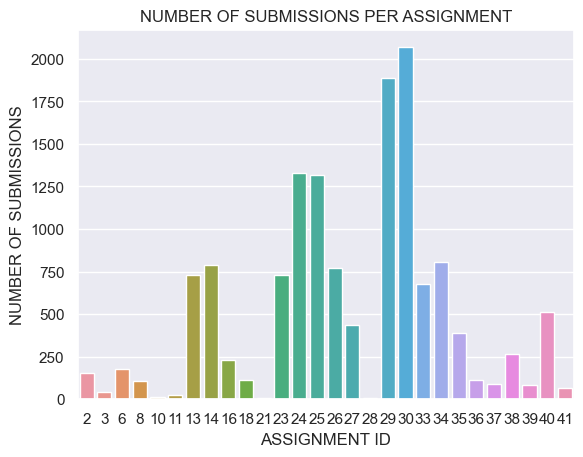

In [21]:
ax = sns.barplot(data=cnt_submissions_per_assignment, x=cnt_submissions_per_assignment.index, y="submission_id")

ax.set(xlabel="ASSIGNMENT ID", 
       ylabel="NUMBER OF SUBMISSIONS", 
       title="NUMBER OF SUBMISSIONS PER ASSIGNMENT")
plt.show()

### 4번 - 각 코스별, 숙제별, 학생별로 처음 만점이 될 때까지의 제출 횟수를 출력하시오. 단 만점이 아닌 경우에는 출력하지 않습니다.

In [22]:
in_time = sub_asnmt[(sub_asnmt["submit_date"] > sub_asnmt["started_date"]) 
                    & (sub_asnmt["submit_date"] < sub_asnmt["ended_date"])]

in_time = in_time[['assignment_id', 'student_id', 'submission_id', 'total_score']]
in_time.head(20)

,assignment_id,student_id,submission_id,total_score
30,2,13,153,100.0
31,2,13,240,100.0
33,2,29,75,50.0
34,2,29,76,50.0
35,2,29,77,50.0
36,2,29,78,50.0
37,2,29,79,75.0
38,2,29,80,50.0
39,2,29,81,75.0
40,2,29,82,75.0


In [23]:
in_time["number_of_try"] = in_time.groupby(["assignment_id", "student_id"]).cumcount() + 1
in_time.head(20)

,assignment_id,student_id,submission_id,total_score,number_of_try
30,2,13,153,100.0,1
31,2,13,240,100.0,2
33,2,29,75,50.0,1
34,2,29,76,50.0,2
35,2,29,77,50.0,3
36,2,29,78,50.0,4
37,2,29,79,75.0,5
38,2,29,80,50.0,6
39,2,29,81,75.0,7
40,2,29,82,75.0,8


In [24]:
result_list = []
for ids, temp_df in in_time.groupby(["assignment_id", "student_id"]):
    if 100 in temp_df["total_score"].values.tolist():
        result_list.append(temp_df.loc[temp_df["total_score"] == 100, :].iloc[[0]])

In [25]:
number_of_try_per_student = pd.concat(result_list)
number_of_try_per_student = number_of_try_per_student[["assignment_id", "student_id", "number_of_try"]]
number_of_try_per_student

,assignment_id,student_id,number_of_try
152,2,12,2
30,2,13,1
75,2,15,13
62,2,16,4
110,2,18,7
...,...,...,...
19867,40,205,15
19604,40,206,13
19759,40,208,11
19429,40,209,18


In [43]:
df = number_of_try_per_student[number_of_try_per_student["assignment_id"] == 2]

In [62]:
def check_students_tries(title, datframe):    
    plt.title(title)
    sns.barplot(data=datframe, x="student_id", y="number_of_try")
    plt.show()

Text(0, 0.5, 'asdf')

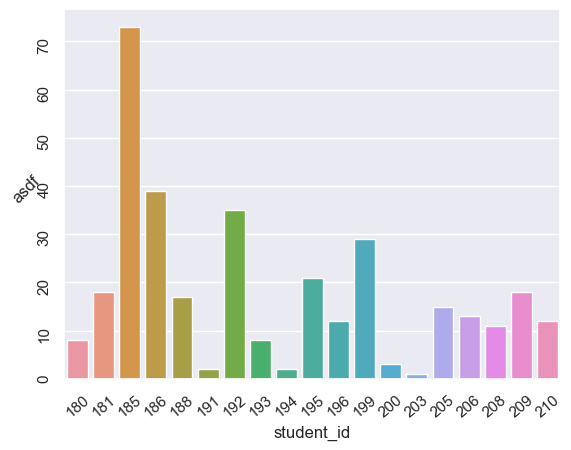

In [77]:
sns.barplot(data=tmpdf, x="student_id", y="number_of_try");
plt.xticks(rotation=40);
plt.yticks(rotation=90);
plt.ylabel(rotation=45, ylabel="asdf")

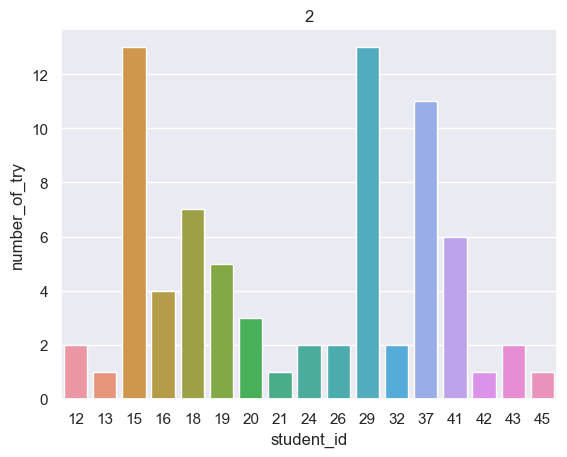

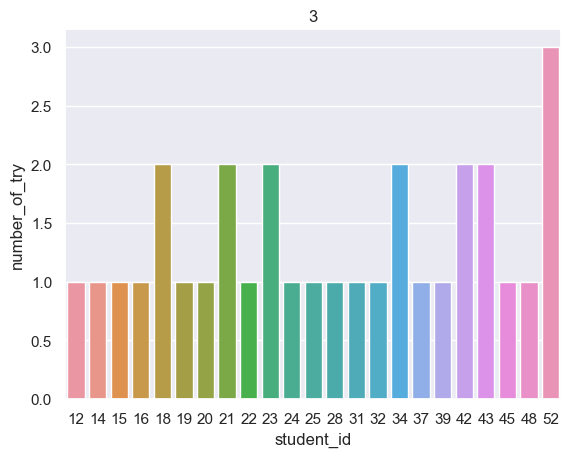

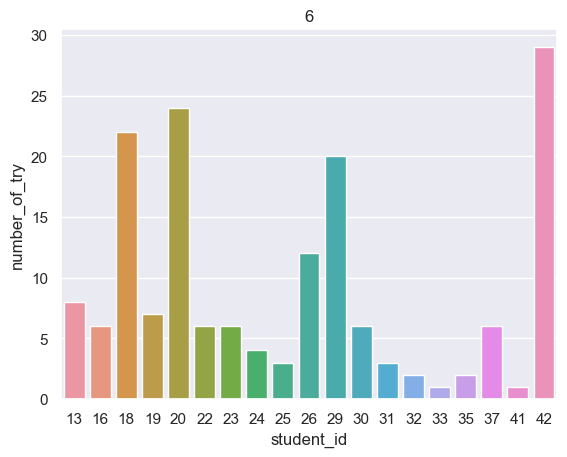

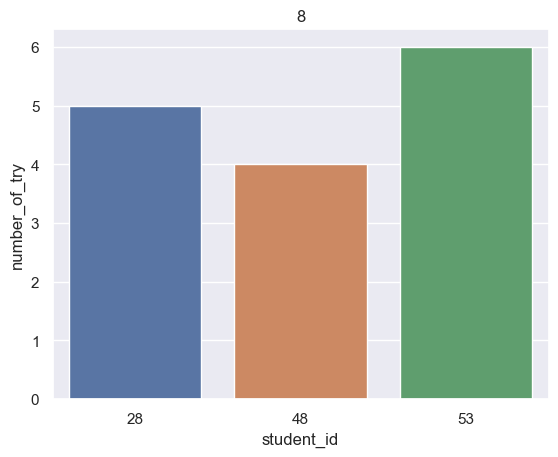

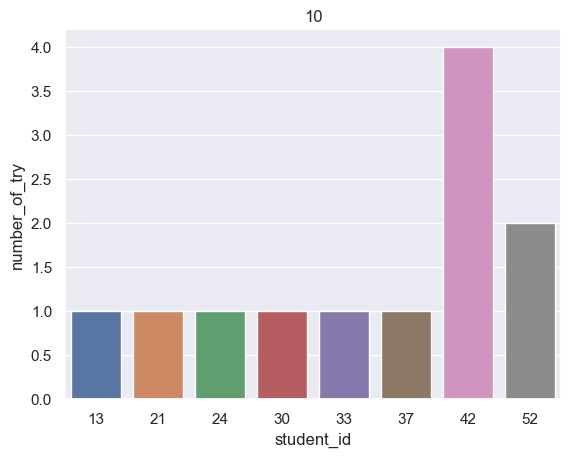

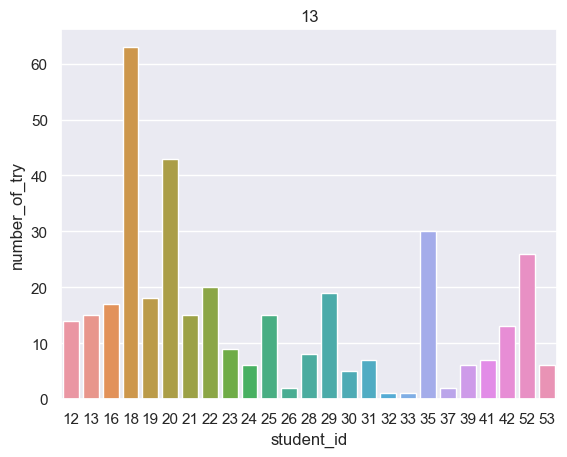

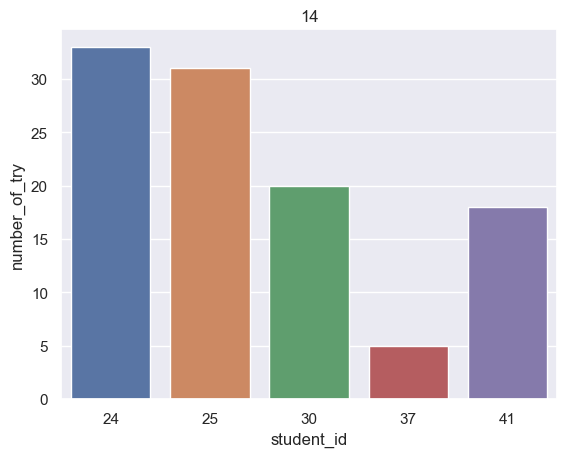

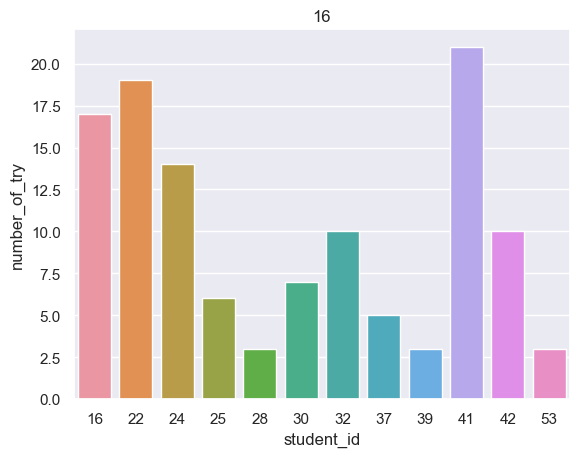

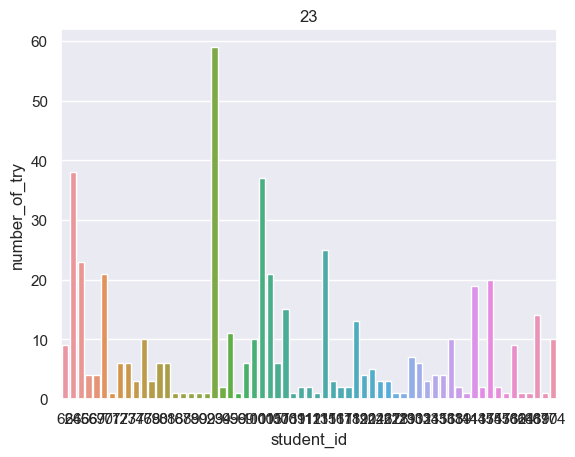

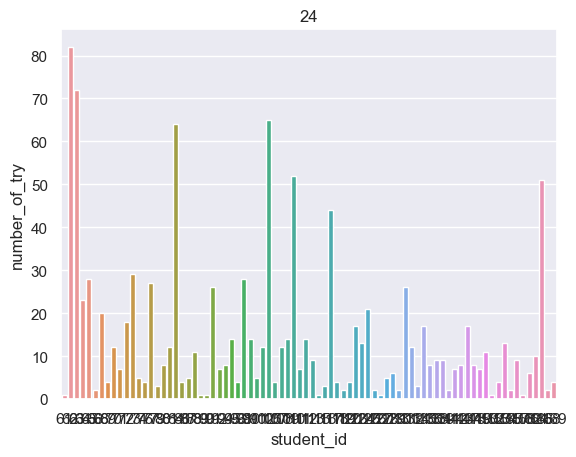

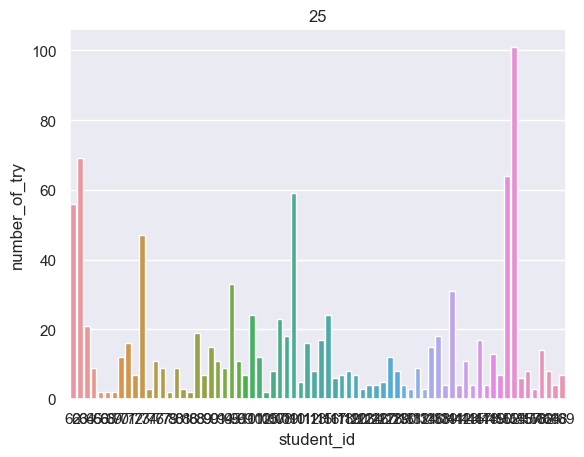

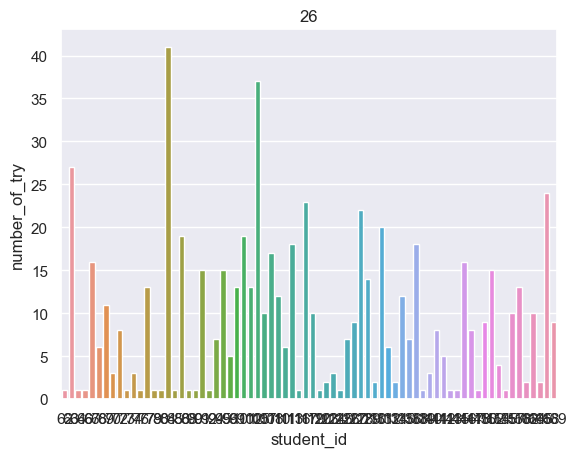

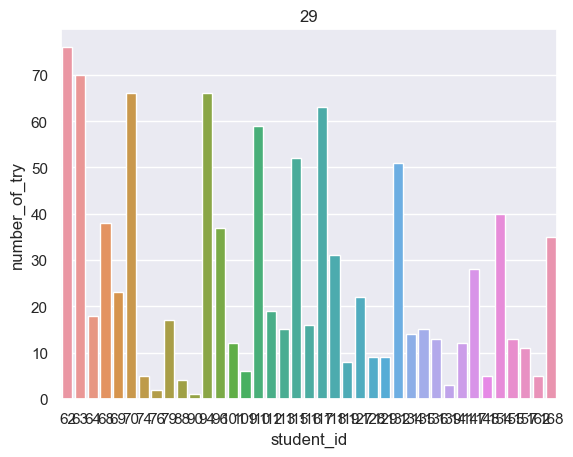

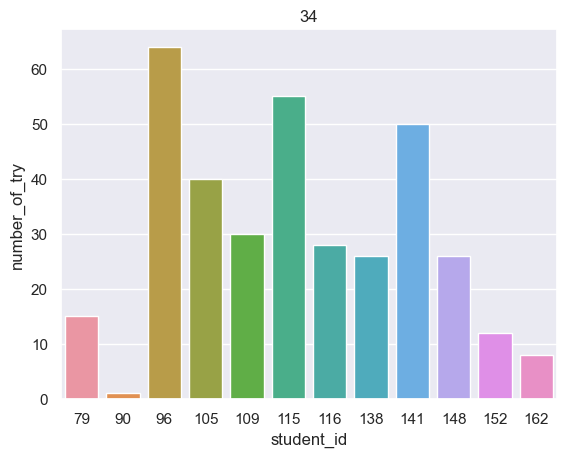

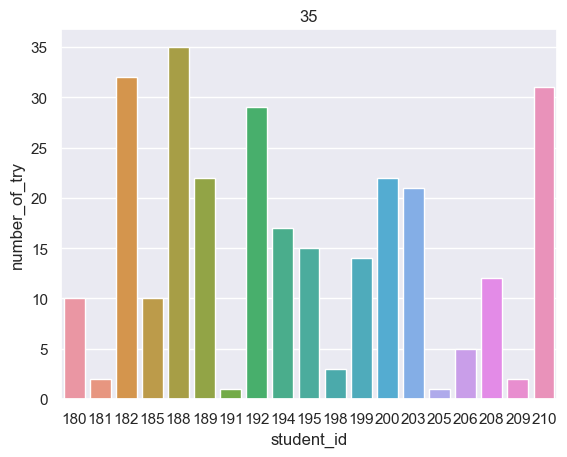

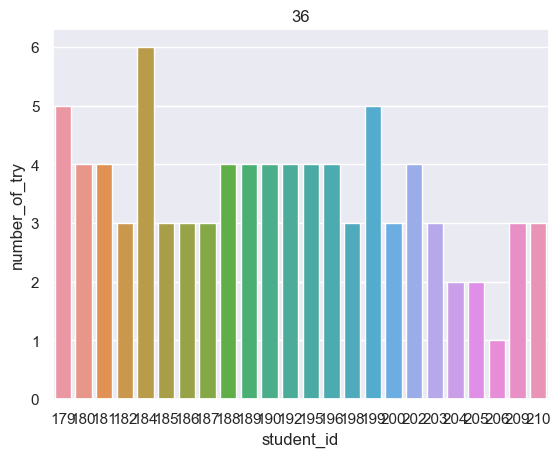

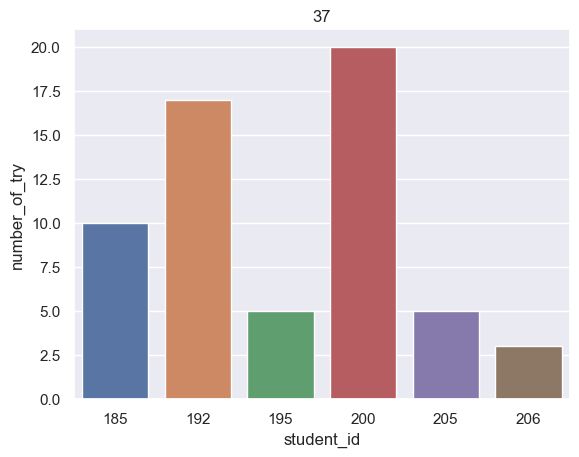

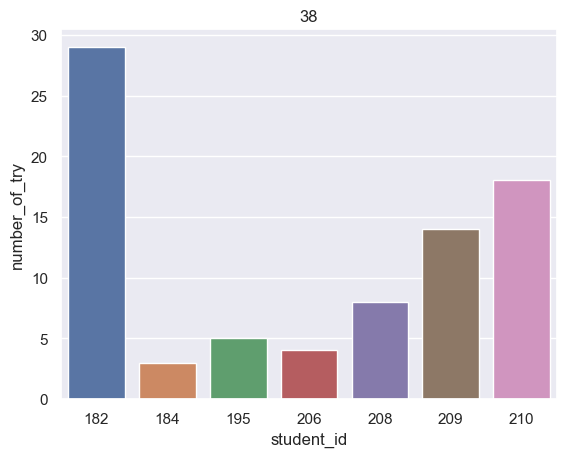

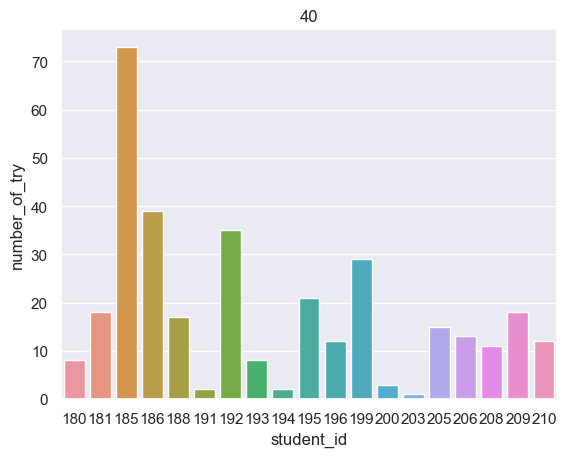

In [63]:
for id_, tmpdf in number_of_try_per_student.groupby("assignment_id"):
    check_students_tries(id_, tmpdf)

/opt/homebrew/Caskroom/miniconda/base/envs/da/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/da/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 82.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/da/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/da/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

[]

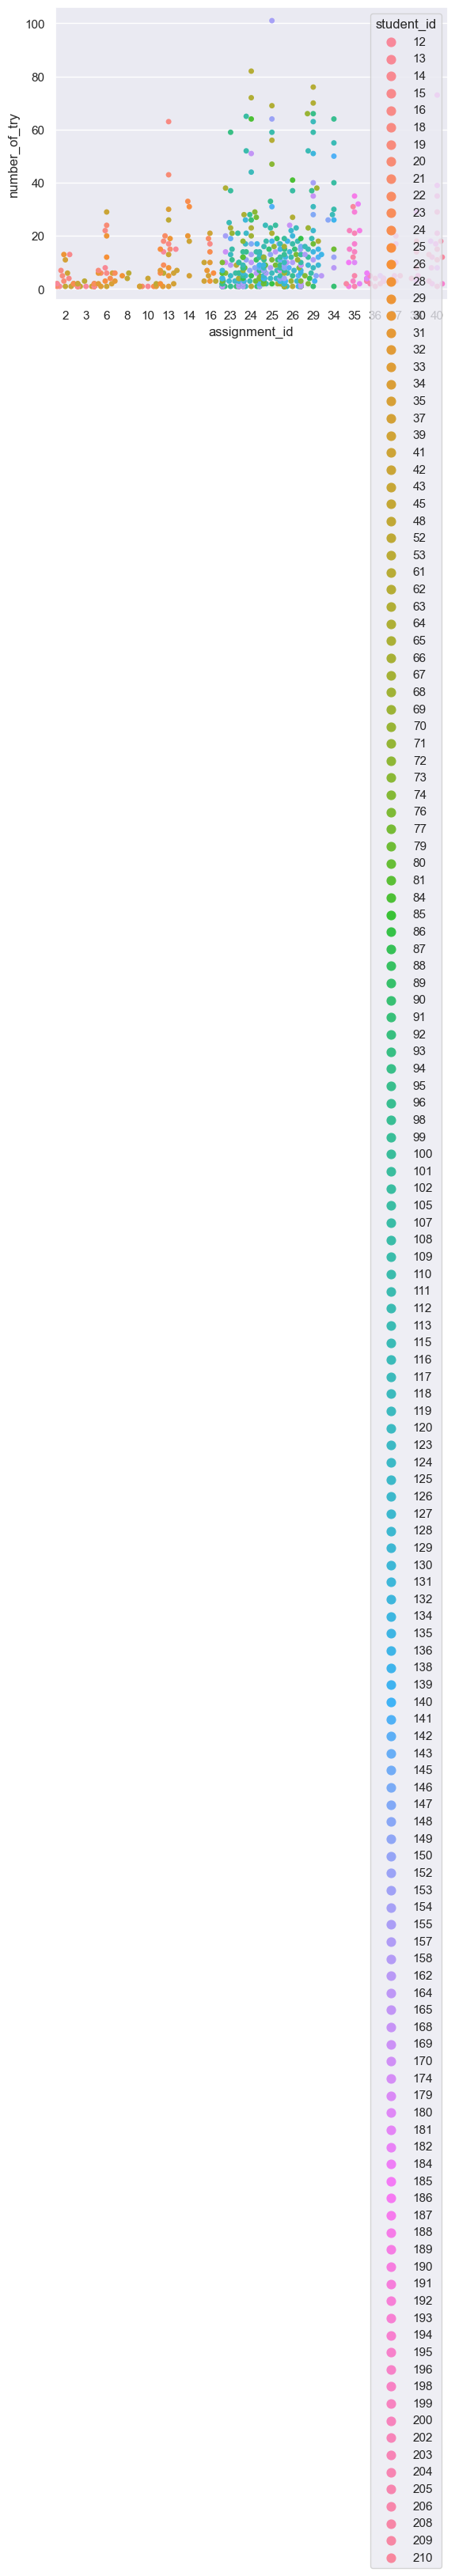

In [26]:
sns.swarmplot(data=number_of_try_per_student, x="assignment_id", y="number_of_try", hue = "student_id")
plt.plot()

### 8. 각 코스별, 각 숙제별로 학생들이 처음 제출한 시간과 마지막으로 제출한 시간을 출력하시오   

In [27]:
in_time = sub_asnmt[(sub_asnmt["submit_date"] > sub_asnmt["started_date"]) 
                    & (sub_asnmt["submit_date"] < sub_asnmt["ended_date"])]

in_time = in_time[["assignment_id", "student_id", "submit_date"]]
in_time.head()

,assignment_id,student_id,submit_date
30,2,13,2021-09-20 18:30:21
31,2,13,2021-09-23 10:58:08
33,2,29,2021-09-20 01:00:57
34,2,29,2021-09-20 01:01:37
35,2,29,2021-09-20 01:03:21


In [28]:
min_max_time_per_assignment = in_time.groupby(["assignment_id"]).agg(
    {"submit_date": ["min", "max"]}
)
min_max_time_per_assignment.head()

submit_date                    
                              min                 max
assignment_id                                        
2             2021-09-20 00:53:24 2021-09-24 23:51:11
3             2021-09-18 14:30:01 2021-10-01 00:32:52
6             2021-09-23 10:35:09 2021-09-23 23:33:24
8             2021-09-23 16:06:08 2021-09-23 23:58:16
10            2021-09-26 21:35:40 2021-10-02 15:03:38

In [29]:
min_max_time_per_assignment = min_max_time_per_assignment.droplevel(axis = 1, level=0)
min_max_time_per_assignment.head()

,min,max
assignment_id,,
2,2021-09-20 00:53:24,2021-09-24 23:51:11
3,2021-09-18 14:30:01,2021-10-01 00:32:52
6,2021-09-23 10:35:09,2021-09-23 23:33:24
8,2021-09-23 16:06:08,2021-09-23 23:58:16
10,2021-09-26 21:35:40,2021-10-02 15:03:38


In [ ]:
싫어.

In [30]:
from datetime import timedelta

In [31]:
df = min_max_time_per_assignment

In [32]:
df["task_duration"] = \
(df["max"] - df["min"]) + timedelta(days=1)

In [33]:
df['days_to_end'] = (df['max'] - df['min'].min()).dt.days

In [34]:
df["min"].min()

Timestamp('2021-09-18 14:30:01')

In [35]:
# datetime_series = 
pd.date_range(start=df["min"].min(), end=df["max"].max())

DatetimeIndex(['2021-09-18 14:30:01', '2021-09-19 14:30:01',
               '2021-09-20 14:30:01', '2021-09-21 14:30:01',
               '2021-09-22 14:30:01', '2021-09-23 14:30:01',
               '2021-09-24 14:30:01', '2021-09-25 14:30:01',
               '2021-09-26 14:30:01', '2021-09-27 14:30:01',
               ...
               '2022-12-01 14:30:01', '2022-12-02 14:30:01',
               '2022-12-03 14:30:01', '2022-12-04 14:30:01',
               '2022-12-05 14:30:01', '2022-12-06 14:30:01',
               '2022-12-07 14:30:01', '2022-12-08 14:30:01',
               '2022-12-09 14:30:01', '2022-12-10 14:30:01'],
              dtype='datetime64[ns]', length=449, freq='D')

In [36]:
df = df.reset_index()

In [37]:
df = pd.merge(df, df_assignments[["assignment_id", "course_id"]], on="assignment_id")

In [38]:
def gantt_chart(title, dataframe, width="task_duration", left="min", right="max"):
    
#     x_ticks = pd.date_range(start=dataframe[left].min(), end=dataframe[right].max()).strftime("%Y/%m/%d")
    plt.title(title, fontsize=30)
    plt.barh(y=dataframe.index, 
             width=dataframe[width],
             
             left=dataframe[left] + timedelta(days=1))
    plt.yticks(label=dataframe["assignment_id"])

    plt.show()

In [39]:
df["course_id"].unique()

array(['DSAA-2021', 'PY-2022S', 'DSAA-2022'], dtype=object)

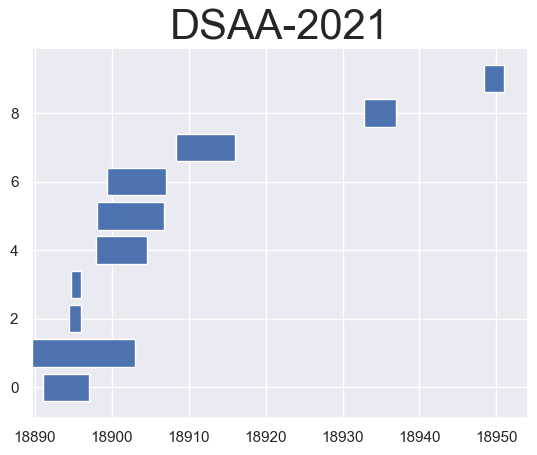

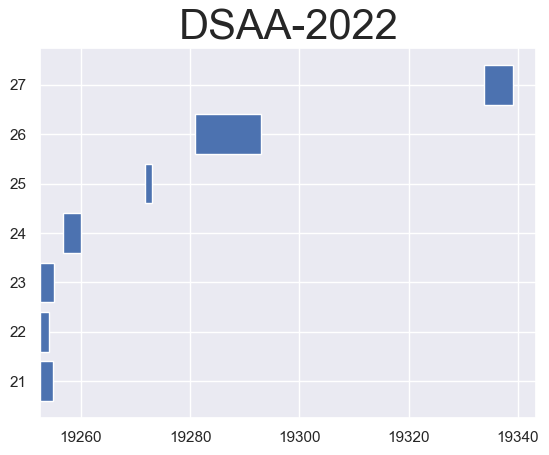

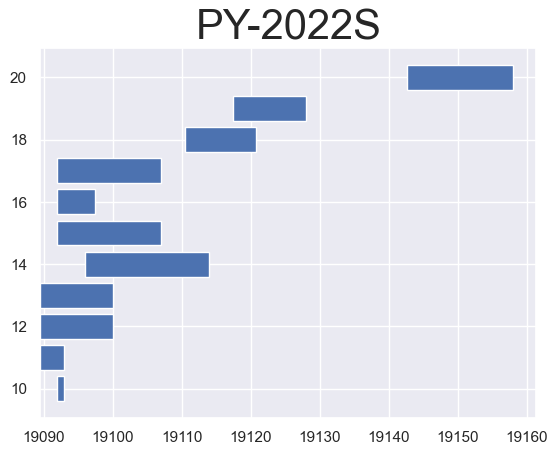

In [40]:
for course_id, tmpdf in df.groupby("course_id"):
    gantt_chart(course_id, tmpdf)

<AxesSubplot:xlabel='assignment_id', ylabel='min'>

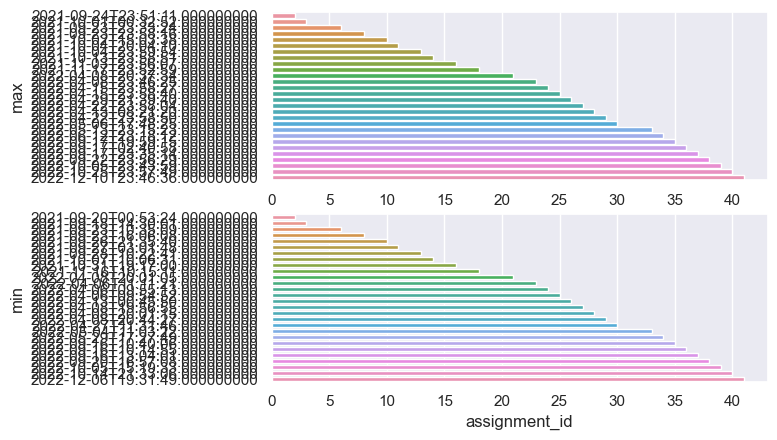

In [41]:
fig, axes = plt.subplots(2, 1)
sns.barplot(data=min_max_time_per_assignment, x=min_max_time_per_assignment.index, y="max", ax=axes[0])
sns.barplot(data=min_max_time_per_assignment, x=min_max_time_per_assignment.index, y="min", ax=axes[1])